# How to control the options of the VQLS solver

The VLQS algorithm has a few options that controls the way the cost function is calculated.

## Step 1: Create your linear system and solver


AAs in the previous tutorials we first create the problem and the solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes

# size of the system
size = 4
nqbit = int(np.log2(size))

# matrix of the linear system
A = np.random.rand(size,size)
A = A + A.T

# right hand side of the linear system
b = np.random.rand(size)

# ansatz for the solver
ansatz = RealAmplitudes(nqbit, entanglement="full", reps=3, insert_barriers=False)

In [2]:
from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms import optimizers as opt

# instantiate an estimator primitive
estimator, sampler, log = Estimator(), Sampler(), VQLSLog([],[])

# create the vqls solver
vqls = VQLS(estimator,ansatz,opt.CG(maxiter=200),callback=log.update,sampler=sampler)

## Step 2 : Define the options

The options can be passed to the `.solve()` method as a dictionnary. The keys of the dictionary are :

In [3]:
opt= {"use_overlap_test": ... ,
      "use_local_cost_function":  ...,
      "matrix_decomposition": ... }

The first two options `use_overlap_test` and `use_local_cost_function` change the ways the cost function is computed. The last one `matrix_decomposition` controls the way the matrix $A$ is decomposed as a serie of quantum circuit

## A - Matrix Decomposition
Two different ways of decomposing the matrix in quantum circuits are implemented. They are respectibely the `SymmetricDecomposition` and the `PauliDecomposition`. 

### Pauli Decomposition
You are probably already familiar with the `PauliDecomposition` that reads:

$$
A = \sum_n c_n P_n
$$

where $P_i$ is the i-th Pauli string, e.g. "XZIY" or "YYZZ". While each Pauli string can be implemented in a very simple quantum circuits, the number of term in the sum above rapidly increases leading to a large number of quantum circuits to evaluate for the calculation of the cost function. Let's see what these circuits look like

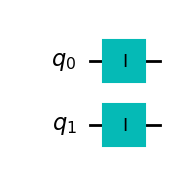

In [13]:
from vqls_prototype import PauliDecomposition 
pauli_decomposition = PauliDecomposition(A)
pauli_decomposition.circuits[0].draw('mpl')

These circuits simply contains a single Pauli gate on each qbit corresponding at the Pauli string.

### Symmetric Decomposition
Another possible decomposition allows to write a real matrix $A$ as a weighted sum of two unitary matrices

$$
A = \frac{1}{2}(A_+ + A_-)
$$

with 

$$
A_\pm = A \pm i\sqrt{I-A^2}
$$

and with $A_\pm$ both unitary matrices. The same analysis can be done for complex matrices bu consdireding their real and imaginary parts separately. Since the matrices $A_\pm$ are unitary they can be implemented in a quantum circuit. Let's take a look at these matrices.

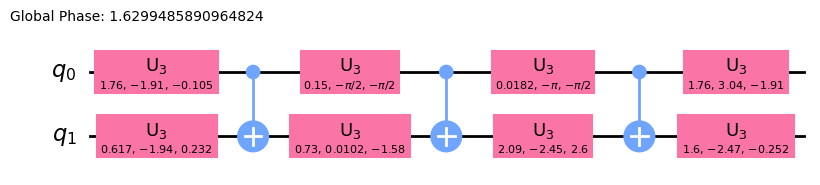

In [5]:
from vqls_prototype import SymmetricDecomposition 
symmetric_decomposition = SymmetricDecomposition(A)
symmetric_decomposition.circuits[0].decompose().draw('mpl')

The `SymmetricDecomposition` leads to only two circuits for a real matrix $A$ but the resulting circuits are much more complicated than the ones obtained via the `PauliDecomposition`



## A - Hadammard or Overlap Hadammard Tests

The global cost function of VQLS require the calculation of: $|\langle b|\Psi\rangle|^2$ that is given after decomposition of the matrix $A$ as $A=\sum_n c_n A_n$:

$$
|\langle b|\Psi\rangle|^2 = \sum_{n,m} c_nc_m^*\langle 0| U^\dagger A_n V|0\rangle\langle 0|V^\dagger A_m^\dagger U|0\rangle
$$

The terms 

$$
\gamma_nm = \langle 0| U^\dagger A_n V|0\rangle\langle 0|V^\dagger A_m^\dagger U|0\rangle
$$

can either be computerd via Hadammard tests or Overlap Hadammard tests. If `use_overlap_test=True`, Hadammard Overlap Tests will be used in place of the regular Hadamard test. Hadammard Overlap Tests use wider circuits but do not require to control the quantum circuits representing the matrix. Let's construct the circuits to see what the are differences between them.

### Hadammard Tests

To create the circuits of the Hadammard test let's use `{"use_overlap_test":False}` as option for the construction of the quantum circuits. This can be done as:

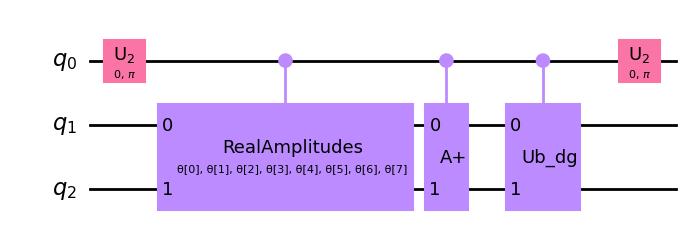

In [6]:
options = vqls._validate_solve_options({"use_overlap_test":False})
_, qc_test = vqls.construct_circuit(A, b, options)
qc_test[0].circuits[0].decompose().draw('mpl')

As you can see the ansatz as well as the $A_n$ and $U$ circuits have to be controlled by the ancillary qubit. 

### Overlap Hadammard Tests
To create the Hadammard Overlap Tests we can simply pass `{"use_overlap_test":False}` as option for the construction of the quantum circuits. This can be done as:

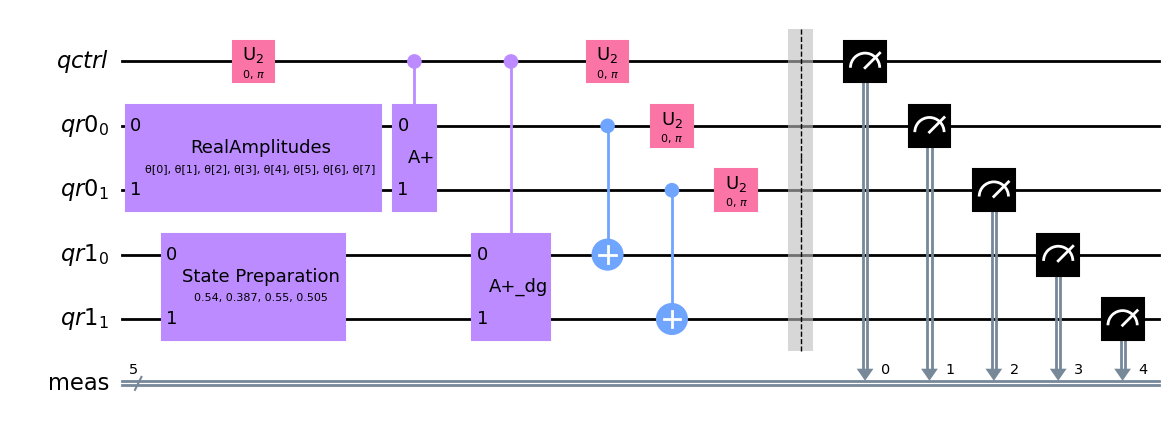

In [7]:
options = vqls._validate_solve_options({"use_overlap_test":True})
_, qc_test = vqls.construct_circuit(A, b, options)
qc_test[0].circuits[0].decompose().draw('mpl')

These circuits are more complicated than the Hadammard test, and use twice more qubits. However the ansatz and the circuit preparing the $|b\rangle$ vector do not need to be controlled by the ancillary qubit. 

## B - Local or Global cost function
Another option allow to switch between the local and the global cost function. As introduced in the original paper, the global cost function is defined by the Hamiltonian:

$$
H_G = A^\dagger(\mathbb{I}-|b\rangle\langle b|) A
$$

while the local cost function is defined via the Hamiltonian:

$$
H_L = A^\dagger U(\mathbb{I}-\frac{1}{n} \sum_n |0_j\rangle\langle 0_j| \otimes \mathbb{I}_{j}) U^\dagger A
$$

When the number of qubit increases it becomes extremely difficult to optimize the global cost function. The local cost function can therefore be used to train large circuits. Let's look a the circuits in both cases

### Local cost function
To create the circuits of the global cost function we can simply use the options :`{"use_local_cost_function":False}` (which is the default anyway). 

In [12]:
options = vqls._validate_solve_options({"use_local_cost_function":False})
_, qc_test = vqls.construct_circuit(A, b, options)
qc_test[0].circuits[0].decompose().draw('mpl')

QiskitError: "Error decomposing node of instruction 'id': 'NoneType' object has no attribute 'global_phase'. Unable to define instruction 'id' in the given basis."

This basically what we have see already above.

### Global cost function
To create the circuits of the local cost function we can simply use the options :`{"use_local_cost_function":True}`.

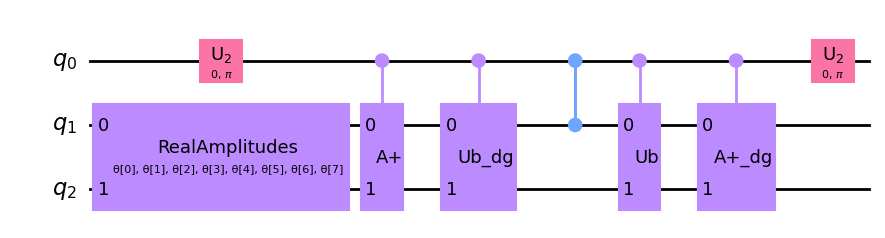

In [9]:
options = vqls._validate_solve_options({"use_local_cost_function":True})
_, qc_test = vqls.construct_circuit(A, b, options)
qc_test[0].circuits[0].decompose().draw('mpl')

Note that it is at the moment not possible to use Hadammard Overlap tests to compute the local cost function.